In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-demand-in-victoria-australia/complete_dataset.csv
/kaggle/input/updated-energy-demand-and-price-victoria-2022/PRICE_AND_DEMAND_202201_VIC1.csv


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

df = pd.read_csv('/kaggle/input/electricity-demand-in-victoria-australia/complete_dataset.csv')

Notebook is divided into 3 sections:
 - EDA/visulaization
 -ARIMA MODEL
 -Regression Model

EDA:

In [3]:
df.set_index('date')
df['rainfall'] = df.fillna(0)['rainfall']
df['solar_exposure'] = df.fillna(method='ffill')['solar_exposure']
df['solar_exposure'] = df.fillna(method='bfill')['solar_exposure']
df.info()
df['date'] = pd.to_datetime(df['date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2106 non-null   float64
 11  rainfall         2106 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB


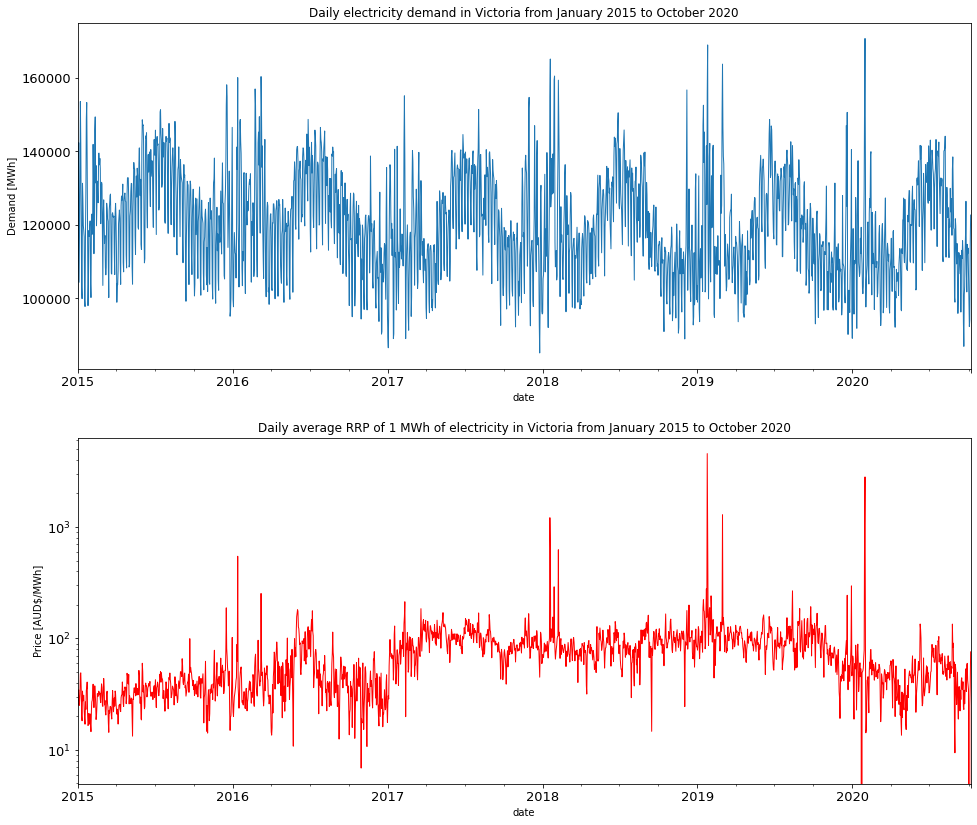

In [4]:
fig, ax = plt.subplots(2, 1, figsize = (16, 14))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=13)

#df['demand'] = df['demand'] / 1000
df.plot(x='date', y='demand', lw = 1, ax = ax[0])
#df['demand'] = df['demand'] * 1000
ax[0].set_title("Daily electricity demand in Victoria from January 2015 to October 2020")
ax[0].set_ylabel("Demand [MWh]")
ax[0].get_legend().remove()

df.plot(x='date', y='RRP', lw = 1, color='red', ax = ax[1])
ax[1].set_title("Daily average RRP of 1 MWh of electricity in Victoria from January 2015 to October 2020")
ax[1].set_ylabel("Price [AUD$/MWh]")
ax[1].get_legend().remove()
plt.yscale("log")


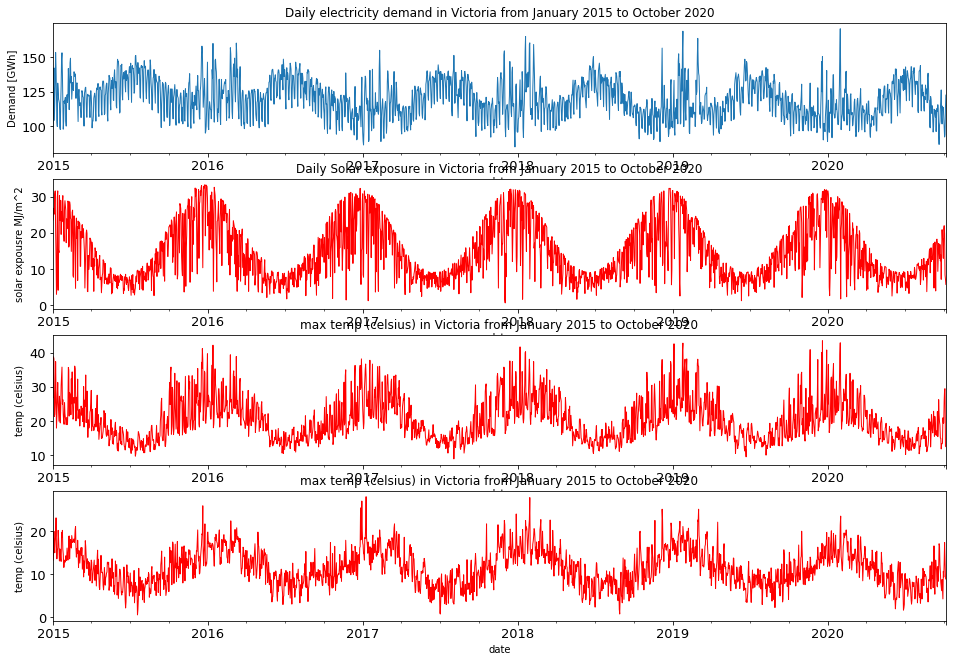

In [5]:
fig, ax = plt.subplots(4, 1, figsize = (16, 11))
ax[0].tick_params(axis='both', which='major', labelsize=13)
ax[1].tick_params(axis='both', which='major', labelsize=13)
ax[2].tick_params(axis='both', which='major', labelsize=13)
ax[3].tick_params(axis='both', which='major', labelsize=13)

df['demand'] = df['demand'] / 1000
df.plot(x='date', y='demand', lw = 1, ax = ax[0])
df['demand'] = df['demand'] * 1000
ax[0].set_title("Daily electricity demand in Victoria from January 2015 to October 2020")
ax[0].set_ylabel("Demand [GWh]")
ax[0].get_legend().remove()

df.plot(x='date', y='solar_exposure', lw = 1, color='red', ax = ax[1])
ax[1].set_title("Daily Solar exposure in Victoria from January 2015 to October 2020")
ax[1].set_ylabel("solar expousre MJ/m^2")
ax[1].get_legend().remove()

df.plot(x='date', y='max_temperature', lw = 1, color='red', ax = ax[2])
ax[2].set_title("max temp (celsius) in Victoria from January 2015 to October 2020")
ax[2].set_ylabel("temp (celsius)")
ax[2].get_legend().remove()

df.plot(x='date', y='min_temperature', lw = 1, color='red', ax = ax[3])
ax[3].set_title("max temp (celsius) in Victoria from January 2015 to October 2020")
ax[3].set_ylabel("temp (celsius)")
ax[3].get_legend().remove()

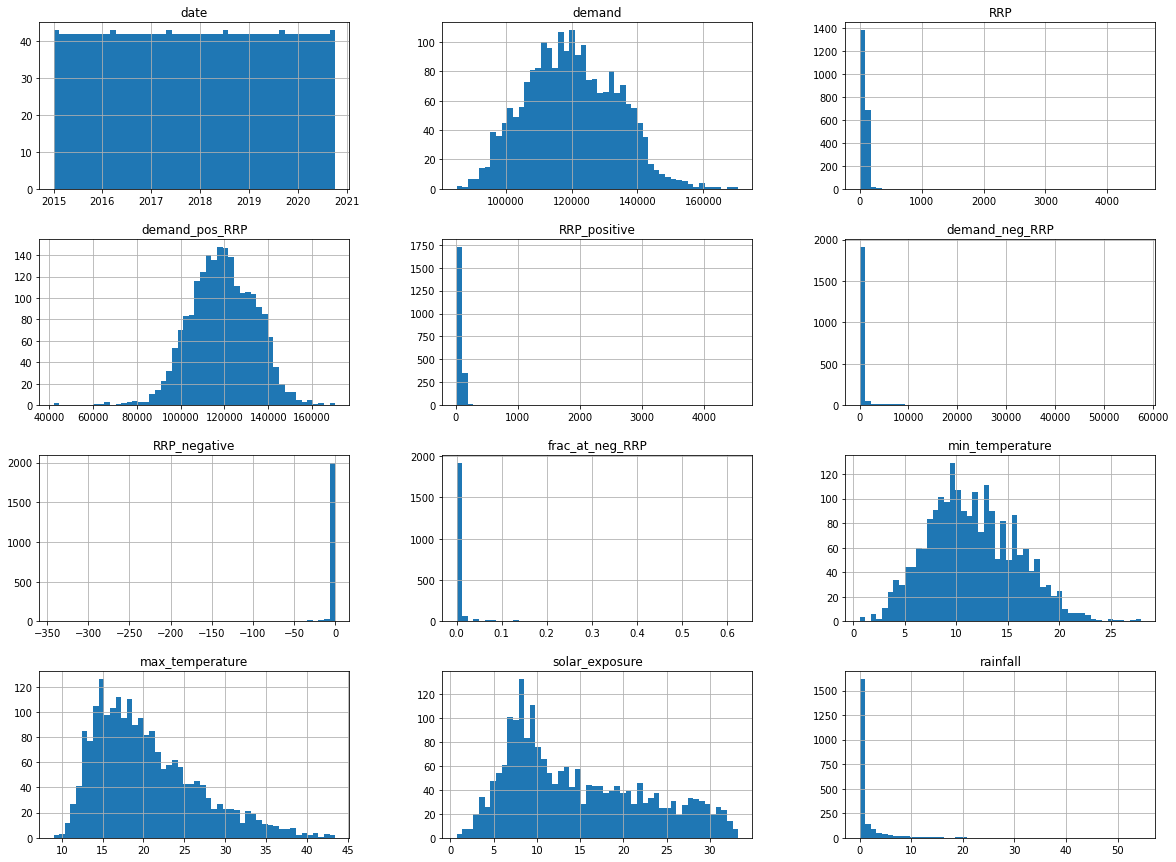

In [6]:
df.hist(bins =50, figsize = (20,15))
plt.show()

In [7]:
df['school_day'].replace(['N','Y'], [0,1], inplace= True)
df['holiday'].replace(['N','Y'], [0,1], inplace = True)
df.corr()

,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
demand,1.000000,0.217538,0.971377,0.215038,-0.180638,0.057854,-0.189839,-0.156118,-0.073216,-0.257471,-0.064662,0.123030,-0.247683
RRP,0.217538,1.000000,0.220856,0.999821,-0.078815,0.038931,-0.077955,0.070619,0.165484,0.061815,-0.028615,-0.005014,-0.030963
demand_pos_RRP,0.971377,0.220856,1.000000,0.214628,-0.409102,0.120054,-0.416573,-0.147020,-0.068146,-0.229813,-0.069770,0.136983,-0.234809
RRP_positive,0.215038,0.999821,0.214628,1.000000,-0.062631,0.029455,-0.061968,0.071052,0.165663,0.061317,-0.027832,-0.006134,-0.030697
demand_neg_RRP,-0.180638,-0.078815,-0.409102,-0.062631,1.000000,-0.274847,0.995590,0.009030,0.000914,-0.037495,0.040491,-0.094577,0.020787
RRP_negative,0.057854,0.038931,0.120054,0.029455,-0.274847,1.000000,-0.258065,-0.077248,-0.033255,0.001672,-0.020861,0.007775,-0.004092
frac_at_neg_RRP,-0.189839,-0.077955,-0.416573,-0.061968,0.995590,-0.258065,1.000000,0.008859,-0.001174,-0.036728,0.038629,-0.096948,0.025606
min_temperature,-0.156118,0.070619,-0.147020,0.071052,0.009030,-0.077248,0.008859,1.000000,0.705433,0.376205,-0.002938,-0.082904,0.066620
max_temperature,-0.073216,0.165484,-0.068146,0.165663,0.000914,-0.033255,-0.001174,0.705433,1.000000,0.598929,-0.154980,-0.092532,0.042487
solar_exposure,-0.257471,0.061815,-0.229813,0.061317,-0.037495,0.001672,-0.036728,0.376205,0.598929,1.000000,-0.123249,-0.095344,0.045196


3- Regression model - adapted from the following notebook: https://www.kaggle.com/lmrojasaguilera/notebook690638ee66

TLDR - this model worked much better than the ARIMA model.  I had also added solar exposure as features which allowed my model to perform much better than the original Author's.  The next step would be to add other variables such as min/max + holidays which have an influence on demand.

In [8]:
df = df.set_index('date')

In [9]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['demand_7_days_lag'] = df['demand'].shift(7)
    df['demand_15_days_lag'] = df['demand'].shift(15)
    df['demand_30_days_lag'] = df['demand'].shift(30)
    df['demand_7_days_mean'] = df['demand'].rolling(window = 7).mean()
    df['demand_15_days_mean'] = df['demand'].rolling(window = 15).mean()
    df['demand_30_days_mean'] = df['demand'].rolling(window = 30).mean()
    df['demand_7_days_std'] = df['demand'].rolling(window = 7).std()
    df['demand_15_days_std'] = df['demand'].rolling(window = 15).std()
    df['demand_30_days_std'] = df['demand'].rolling(window = 30).std()
    df['demand_7_days_max'] = df['demand'].rolling(window = 7).max()
    df['demand_15_days_max'] = df['demand'].rolling(window = 15).max()
    df['demand_30_days_max'] = df['demand'].rolling(window = 30).max()
    df['demand_7_days_min'] = df['demand'].rolling(window = 7).min()
    df['demand_15_days_min'] = df['demand'].rolling(window = 15).min()
    df['demand_30_days_min'] = df['demand'].rolling(window = 30).min()
    df['solar_exposure_7_lag'] = df["solar_exposure"].shift(7)
    df['solar_exposure_15_lag'] = df["solar_exposure"].shift(15)
    df['solar_exposure_30_lag'] = df["solar_exposure"].shift(30)
    df['solar_exposure_30_mean'] = df['solar_exposure'].rolling(window = 30).mean()
    df['solar_exposure_7_mean'] = df['solar_exposure'].rolling(window = 7).mean()
    df['solar_exposure_15_mean'] = df['solar_exposure'].rolling(window = 15).mean()
    df['solar_exposure_30_std'] = df['solar_exposure'].rolling(window = 30).std()
    df['solar_exposure_7_std'] = df['solar_exposure'].rolling(window = 7).std()
    df['solar_exposure_15_std'] = df['solar_exposure'].rolling(window = 15).std()
    df['solar_exposure_30_min'] = df['solar_exposure'].rolling(window = 30).min()
    df['solar_exposure_15_min'] = df['solar_exposure'].rolling(window = 15).min()
    df['solar_exposure_7_min'] = df['solar_exposure'].rolling(window = 7).min()
    df['solar_exposure_30_max'] = df['solar_exposure'].rolling(window = 30).max()
    df['solar_exposure_15_max'] = df['solar_exposure'].rolling(window = 15).max()
    df['solar_exposure_7_max'] = df['solar_exposure'].rolling(window = 7).max()
    
    cols = ['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']
    
    for d in ('7', '15', '30'):
        for c in ('lag', 'mean', 'std', 'max', 'min'):
            cols.append(f'demand_{d}_days_{c}')
            cols.append(f'solar_exposure_{d}_{c}')
    
    X = df[cols]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
df_train = df[0:1740]
df_test = df[1741:]

In [11]:
X_train, y_train = create_features(df_train, label='demand')
X_test, y_test = create_features(df_test, label='demand')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [12]:
X_test.dtypes

hour                        int64
dayofweek                   int64
quarter                     int64
month                       int64
year                        int64
dayofyear                   int64
dayofmonth                  int64
weekofyear                  int64
demand_7_days_lag         float64
solar_exposure_7_lag      float64
demand_7_days_mean        float64
solar_exposure_7_mean     float64
demand_7_days_std         float64
solar_exposure_7_std      float64
demand_7_days_max         float64
solar_exposure_7_max      float64
demand_7_days_min         float64
solar_exposure_7_min      float64
demand_15_days_lag        float64
solar_exposure_15_lag     float64
demand_15_days_mean       float64
solar_exposure_15_mean    float64
demand_15_days_std        float64
solar_exposure_15_std     float64
demand_15_days_max        float64
solar_exposure_15_max     float64
demand_15_days_min        float64
solar_exposure_15_min     float64
demand_30_days_lag        float64
solar_exposure

In [13]:
reg = xgb.XGBRegressor(n_estimators=2000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=200,
       verbose=True) 

[0]	validation_0-rmse:85545.53906	validation_1-rmse:80970.69531
[1]	validation_0-rmse:60243.64453	validation_1-rmse:56784.23828
[2]	validation_0-rmse:42601.95703	validation_1-rmse:40036.53125
[3]	validation_0-rmse:30361.14648	validation_1-rmse:28285.24805
[4]	validation_0-rmse:21849.27930	validation_1-rmse:20497.98438
[5]	validation_0-rmse:16004.18262	validation_1-rmse:15313.25879
[6]	validation_0-rmse:11986.10938	validation_1-rmse:12267.65332
[7]	validation_0-rmse:9237.95117	validation_1-rmse:10568.96094
[8]	validation_0-rmse:7426.02002	validation_1-rmse:9584.51856
[9]	validation_0-rmse:6263.91406	validation_1-rmse:9176.13281
[10]	validation_0-rmse:5468.02393	validation_1-rmse:8937.12695
[11]	validation_0-rmse:5044.60107	validation_1-rmse:8991.51465
[12]	validation_0-rmse:4601.38672	validation_1-rmse:9134.26074
[13]	validation_0-rmse:4368.03369	validation_1-rmse:9114.64844
[14]	validation_0-rmse:4101.89209	validation_1-rmse:9126.22461
[15]	validation_0-rmse:3891.69678	validation_1-rms

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

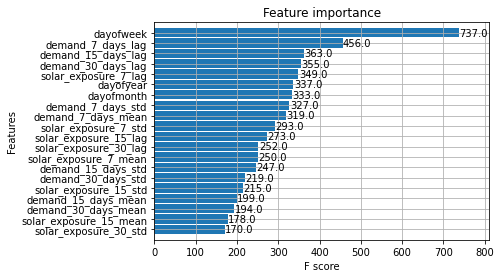

In [14]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 20)

In [15]:
df_test['pred'] = reg.predict(X_test)
d_all = pd.concat([df_test, df_train], sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


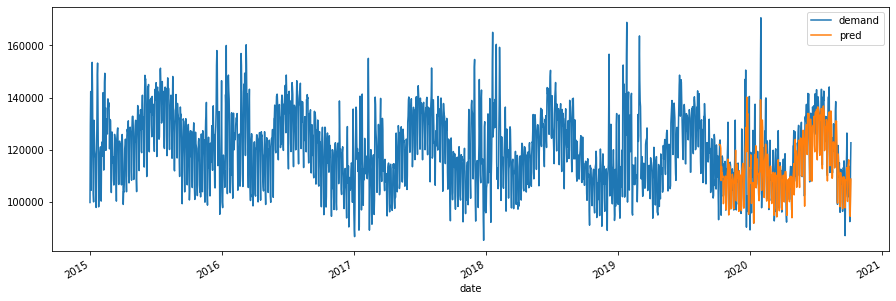

In [16]:
_ = d_all[['demand','pred']].plot(figsize=(15, 5))

In [17]:
np.sqrt(mean_squared_error(y_true=df_test['demand'],
                   y_pred=df_test['pred']))

8937.12716811806

In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mean_absolute_percentage_error(y_true=df_test['demand'],
                   y_pred=df_test['pred'])

5.3307021488380215